## 100% Accuracy in Classification model of NG and OK class in Hyundai Santro Car Engine.

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#### Dataloaders

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        # transforms.CenterCrop(476),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes = dict()
for x in ['train', 'val']:
    dataset_sizes[x] = len(image_datasets[x])
    print(f'{x} dataset size : {dataset_sizes[x]}')


class_names = image_datasets['train'].classes
print(f'\nclasses name : {class_names}')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device type : {device}')

train dataset size : 132
val dataset size : 20

classes name : ['ng', 'ok']
device type : cpu


ng : 39
ok : 93


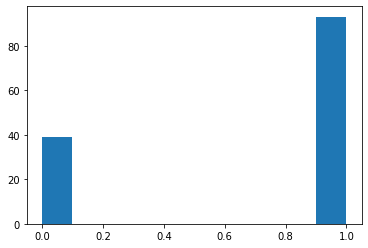

In [6]:
dts = np.array(image_datasets['train'].targets)
plt.hist(dts)
ng_dataset_size = len(image_datasets['train']) - sum(dts)
print(f'{class_names[0]} : { len(image_datasets["train"]) - int(sum(dts))}')
print(f'{class_names[1]} : {int(sum(dts))}')

# the ratio of both the classes is between 30-70 so no need to balance datasets

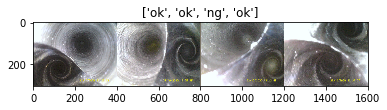

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Model Training

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,    num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6580 Acc: 0.6515
val Loss: 0.6657 Acc: 0.7000

Epoch 1/24
----------
train Loss: 0.6090 Acc: 0.7045
val Loss: 0.5064 Acc: 0.7000

Epoch 2/24
----------
train Loss: 0.5348 Acc: 0.7197
val Loss: 0.3967 Acc: 0.8500

Epoch 3/24
----------
train Loss: 0.6729 Acc: 0.6894
val Loss: 0.2804 Acc: 0.8500

Epoch 4/24
----------
train Loss: 0.5602 Acc: 0.7045
val Loss: 0.2909 Acc: 0.9500

Epoch 5/24
----------
train Loss: 0.5039 Acc: 0.7500
val Loss: 0.2476 Acc: 0.9500

Epoch 6/24
----------
train Loss: 0.4775 Acc: 0.7879
val Loss: 0.1944 Acc: 0.9500

Epoch 7/24
----------
train Loss: 0.4407 Acc: 0.7652
val Loss: 0.1925 Acc: 0.9500

Epoch 8/24
----------
train Loss: 0.3719 Acc: 0.8485
val Loss: 0.1423 Acc: 0.9500

Epoch 9/24
----------
train Loss: 0.3806 Acc: 0.8030
val Loss: 0.1416 Acc: 0.9500

Epoch 10/24
----------
train Loss: 0.3770 Acc: 0.8182
val Loss: 0.1316 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.4463 Acc: 0.8106
val Loss: 0.1765 Acc: 0.9500

Ep

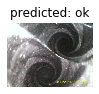

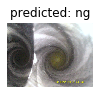

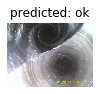

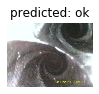

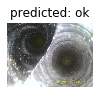

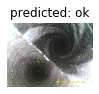

In [20]:
visualize_model(model_ft)

#### Model Saving / Loading

In [19]:
# PATH = './final.pth'
# torch.save(model_ft.state_dict(), PATH)

checkpoint = {'model': model_ft,
          'state_dict': model_ft.state_dict(),
          'optimizer' : optimizer_ft.state_dict()}

torch.save(checkpoint, 'model.pth')

In [22]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('model.pth')

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  